In [1]:
#Setup: load necessary libraries ---------------------------------------------------------------------
suppressPackageStartupMessages({
    library(dplyr)
    library(Seurat)
    library(patchwork)
    library(ggplot2)
    library(SingleR)
    library(celldex)
    library(pheatmap)
    library(DT)
})

In [2]:
#Paths to files and output directory defined for various results
data_dir   <- "filtered_gene_bc_matrices/hg19"
output_dir <- "sc_analysis_results_pbmc"
dir.create(output_dir, showWarnings = FALSE)

In [3]:
#Load data & create Seurat object -----------------------------------------
pbmc_counts <- Read10X(data.dir = data_dir)
pbmc <- suppressWarnings(CreateSeuratObject(
  counts     = pbmc_counts,
  project    = "pbmc3k",
  min.cells  = 3,
  min.features = 200
))

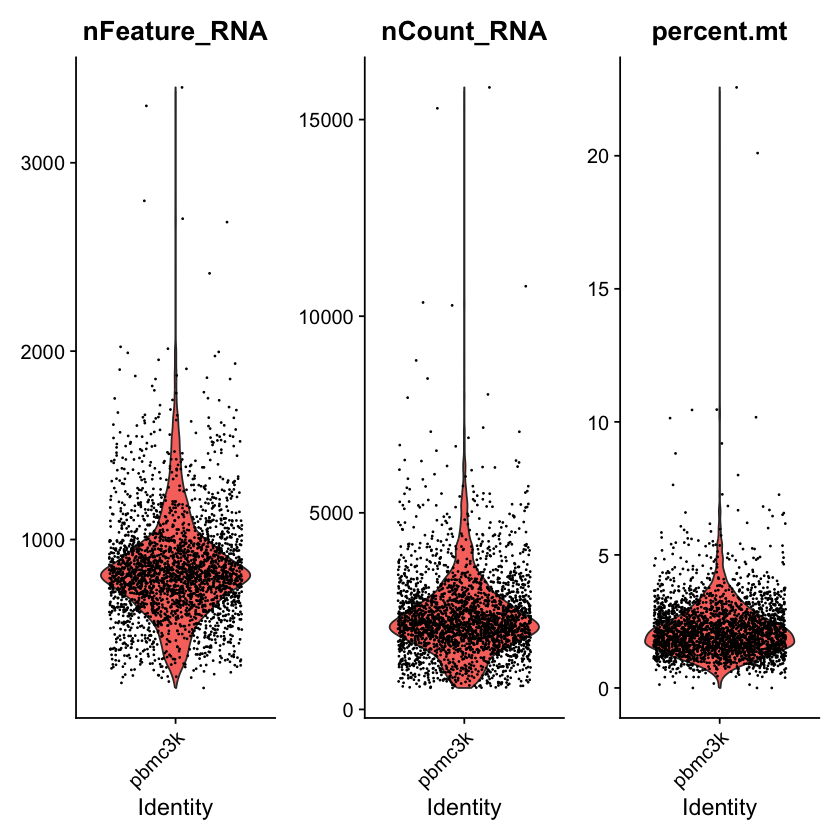

In [4]:
#QC & filtering ------------------------------------------------------------
#Calculate percent mitochondrial genes
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

#Violin plots of QC metrics
qc_vln <- suppressWarnings(VlnPlot(
  pbmc,
  features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
  ncol     = 3
))
qc_vln
ggsave(file.path(output_dir, "QC_violin.png"), qc_vln, width = 9, height = 3)

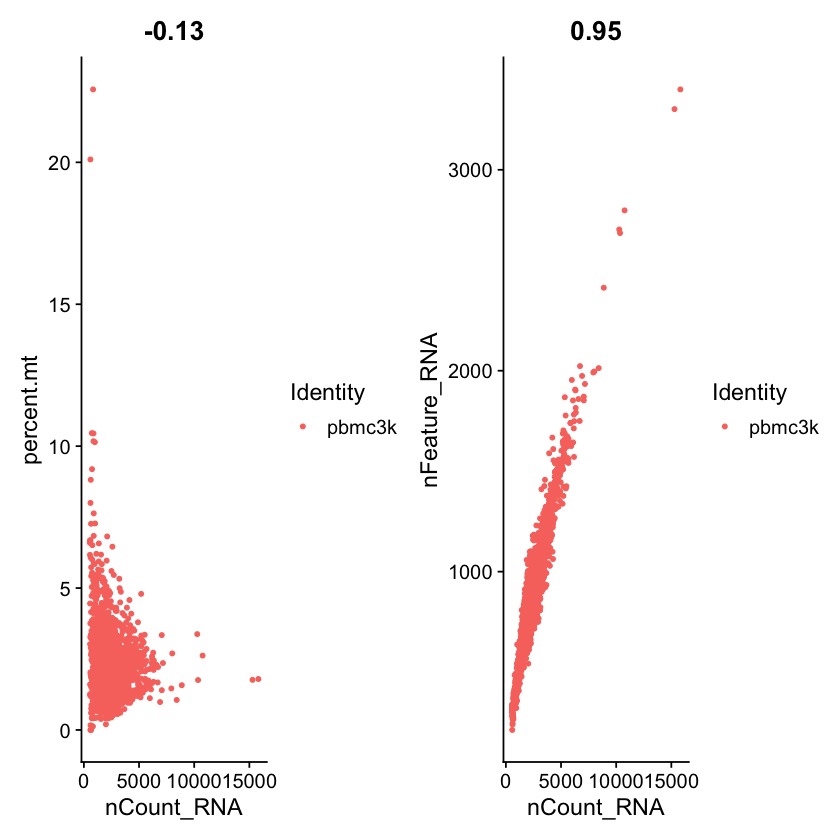

In [5]:
#Scatter plots for QC
qc_scatter1 <- FeatureScatter(pbmc, "nCount_RNA", "percent.mt")
qc_scatter2 <- FeatureScatter(pbmc, "nCount_RNA", "nFeature_RNA")
qc_scatter1 + qc_scatter2
ggsave(file.path(output_dir, "QC_scatter.png"), qc_scatter1 + qc_scatter2, width = 6, height = 3)

In [6]:
#Filter cells: keep 200 < nFeature_RNA < 2500 & percent.mt < 5%
cat("Cells before filtering:", ncol(pbmc), "\n")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
cat("Cells after filtering: ", ncol(pbmc), "\n")

Cells before filtering: 2700 
Cells after filtering:  2638 


In [7]:
#Normalize & identify variable features -----------------------------------
pbmc <- suppressMessages(
  NormalizeData(
    pbmc,
    normalization.method = "LogNormalize",
    scale.factor = 1e4,
    verbose = FALSE
  )
)

pbmc <- suppressMessages(
  FindVariableFeatures(
    pbmc,
    selection.method = "vst",
    nfeatures = 2000,
    verbose = FALSE
  )
)
top10 <- head(VariableFeatures(pbmc), 10)
#Create and display your table
top10_df <- data.frame(Rank = 1:10, Gene = top10)
datatable(
  top10_df,
  rownames = FALSE,
  options = list(
    paging = FALSE,
    searching = FALSE,
    info = FALSE
  )
)

HTML widgets cannot be represented in plain text (need html)

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


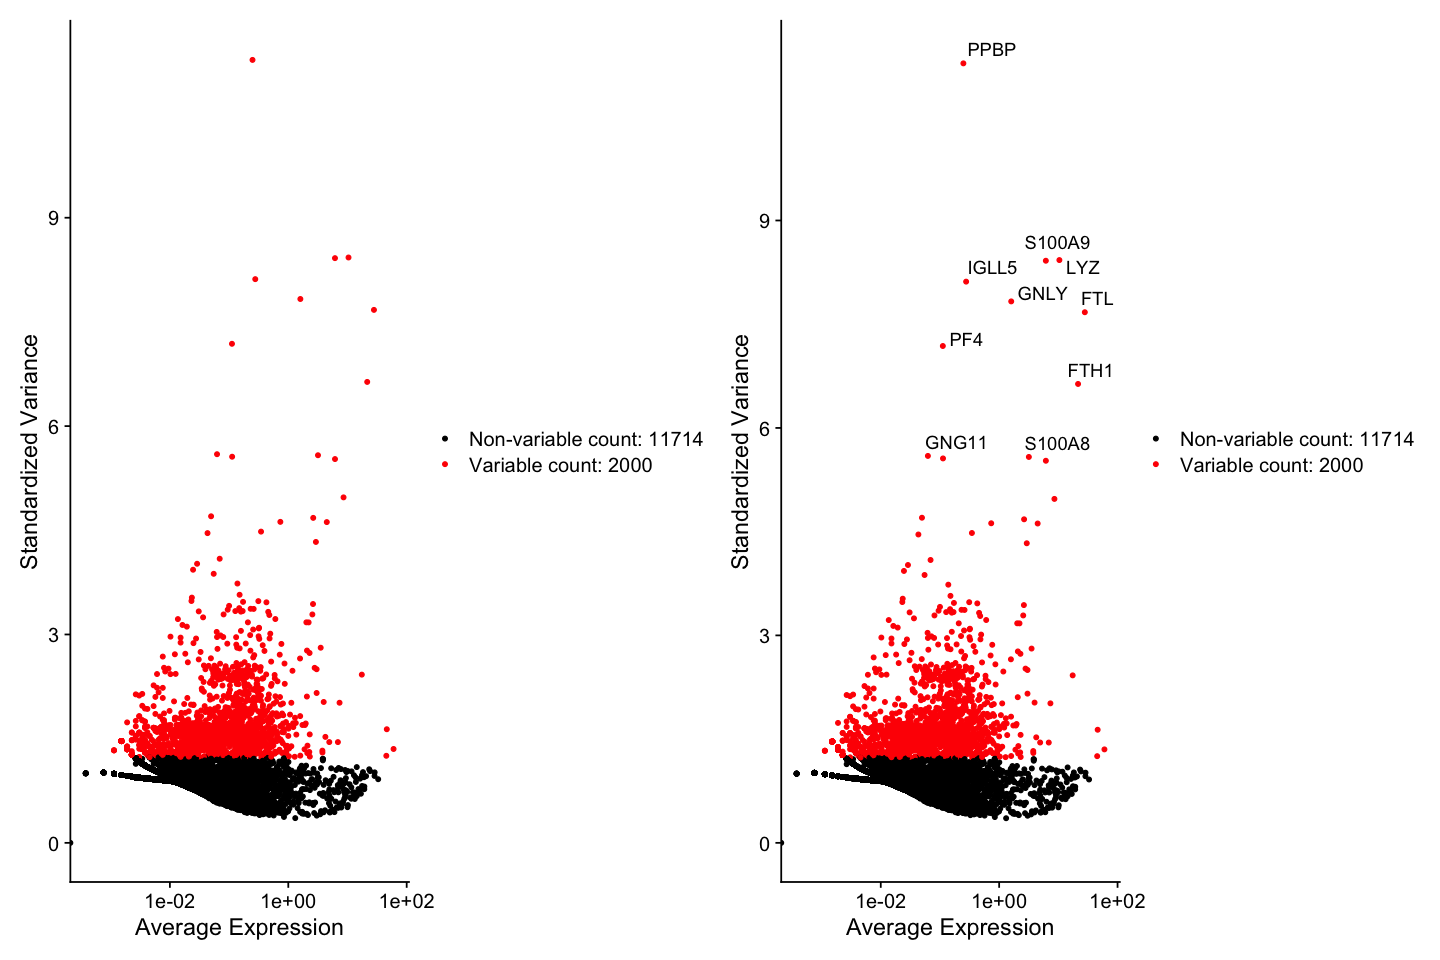

In [8]:
#Plot top variable features
options(repr.plot.width = 12, repr.plot.height = 8)
plot1 <- suppressMessages(VariableFeaturePlot(pbmc))
plot2 <- suppressMessages(LabelPoints(plot = plot1, points = top10, repel = TRUE))
plot1 + plot2
ggsave(file.path(output_dir, "VariableFeatures.png"), plot2, width = 6, height = 4)

[1] "PC_ 1 "                                                
 [2] "Positive:  CST3, TYROBP, LST1, AIF1, FTL "             
 [3] "Negative:  MALAT1, LTB, IL32, IL7R, CD2 "              
 [4] "PC_ 2 "                                                
 [5] "Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 "   
 [6] "Negative:  NKG7, PRF1, CST7, GZMB, GZMA "              
 [7] "PC_ 3 "                                                
 [8] "Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 "
 [9] "Negative:  PPBP, PF4, SDPR, SPARC, GNG11 "             
[10] "PC_ 4 "                                                
[11] "Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 "   
[12] "Negative:  VIM, IL7R, S100A6, IL32, S100A8 "           
[13] "PC_ 5 "                                                
[14] "Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY "          
[15] "Negative:  LTB, IL7R, CKB, VIM, MS4A7 "

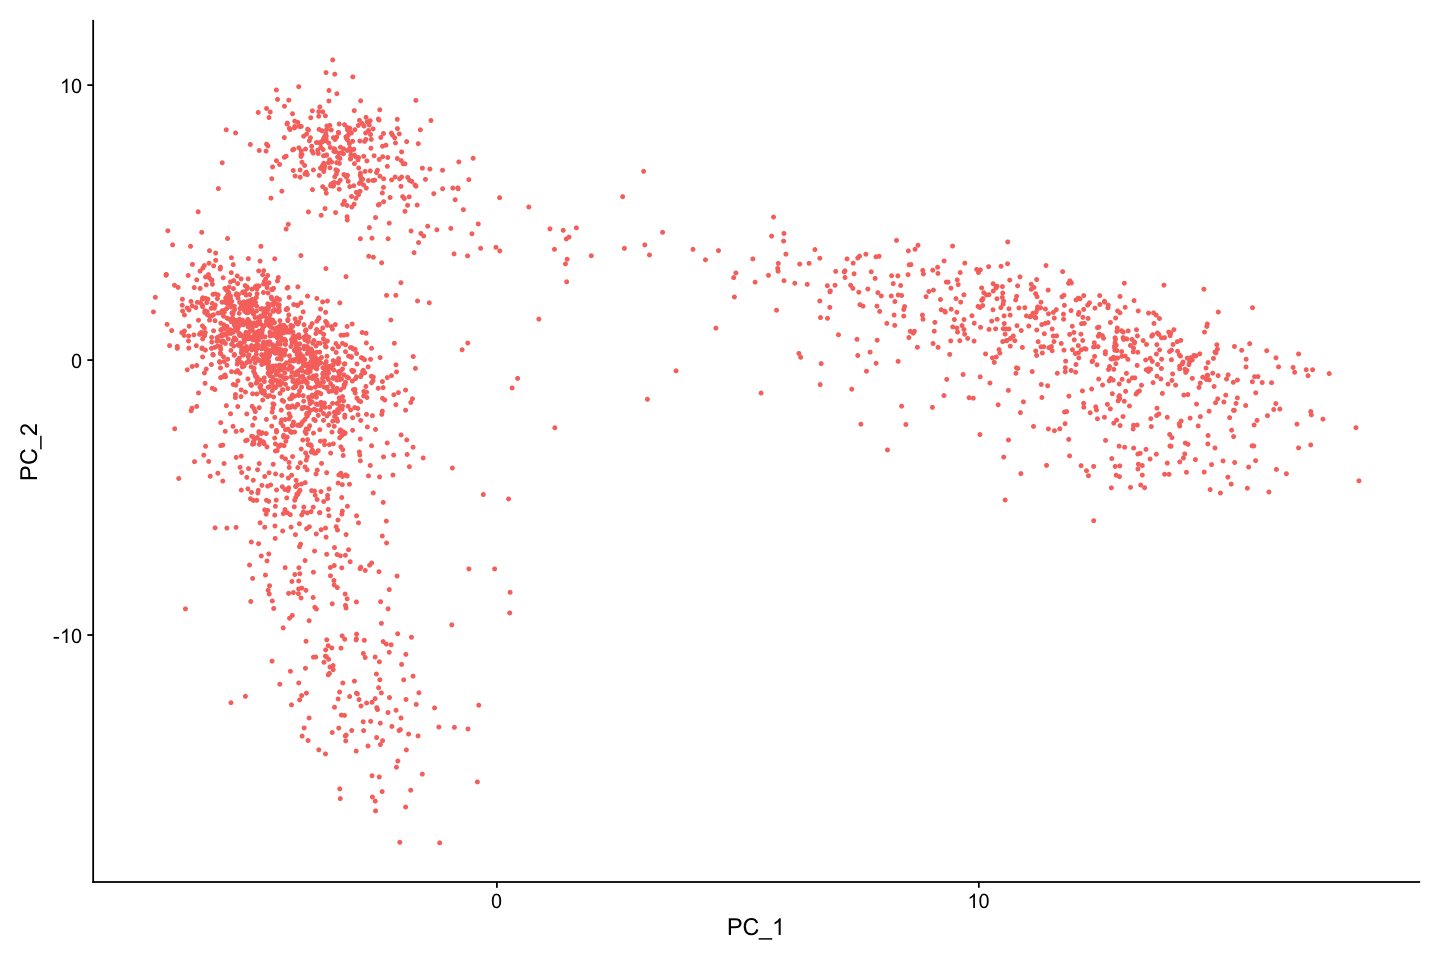

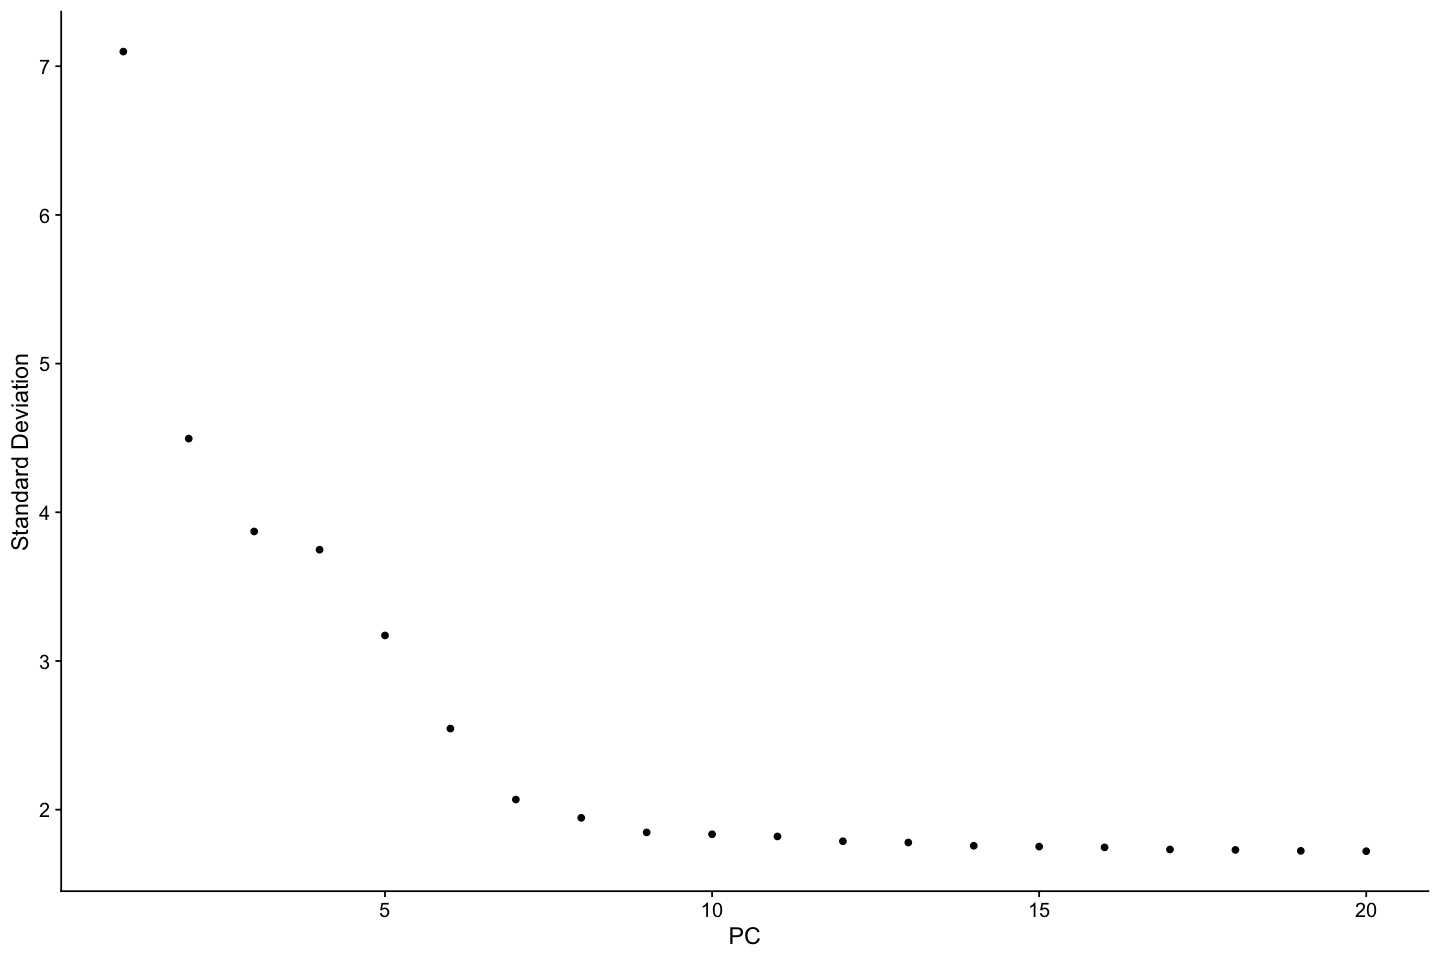

In [9]:
#Scale data & PCA ---------------------------------------------------------
pbmc <- suppressMessages(ScaleData(pbmc, features = rownames(pbmc)))
pbmc <- suppressMessages(RunPCA(pbmc, features = VariableFeatures(pbmc)))

#PCA diagnostics
pca_print <- capture.output(print(pbmc[["pca"]], dims = 1:5, nfeatures = 5))
cat(paste(pca_print, collapse = "\n"), "\n", file = file.path(output_dir, "PCA_top_features.txt"))
pca_print

pca_plot <- DimPlot(pbmc, reduction = "pca") + NoLegend()
elbow_plot <- ElbowPlot(pbmc)
ggsave(file.path(output_dir, "PCA_plot.png"), pca_plot, width = 4, height = 4)
ggsave(file.path(output_dir, "Elbow_plot.png"), elbow_plot, width = 4, height = 4)
pca_plot
elbow_plot

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95927

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 9
Elapsed time: 0 seconds
Clusters identified: 9 


23:04:51 UMAP embedding parameters a = 0.9922 b = 1.112

23:04:51 Read 2638 rows and found 10 numeric columns

23:04:51 Using Annoy for neighbor search, n_neighbors = 30

23:04:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:04:51 Writing NN index file to temp file /var/folders/01/3sqw50x56v1bb5752s5c04wm0000gn/T//RtmpQNDTM1/file1e63f51ad03

23:04:51 Searching Annoy index using 1 thread, search_k = 3000

23:04:51 Annoy recall = 100%

23:04:53 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

23:04:53 Initializing from normalized Laplacian + noise (using RSpectra)

23:04:53 Commencing optimization for 500 epochs, with 105140 positive edges

23:04:53 Using rng type: pcg

23:04:57 Optimization finished



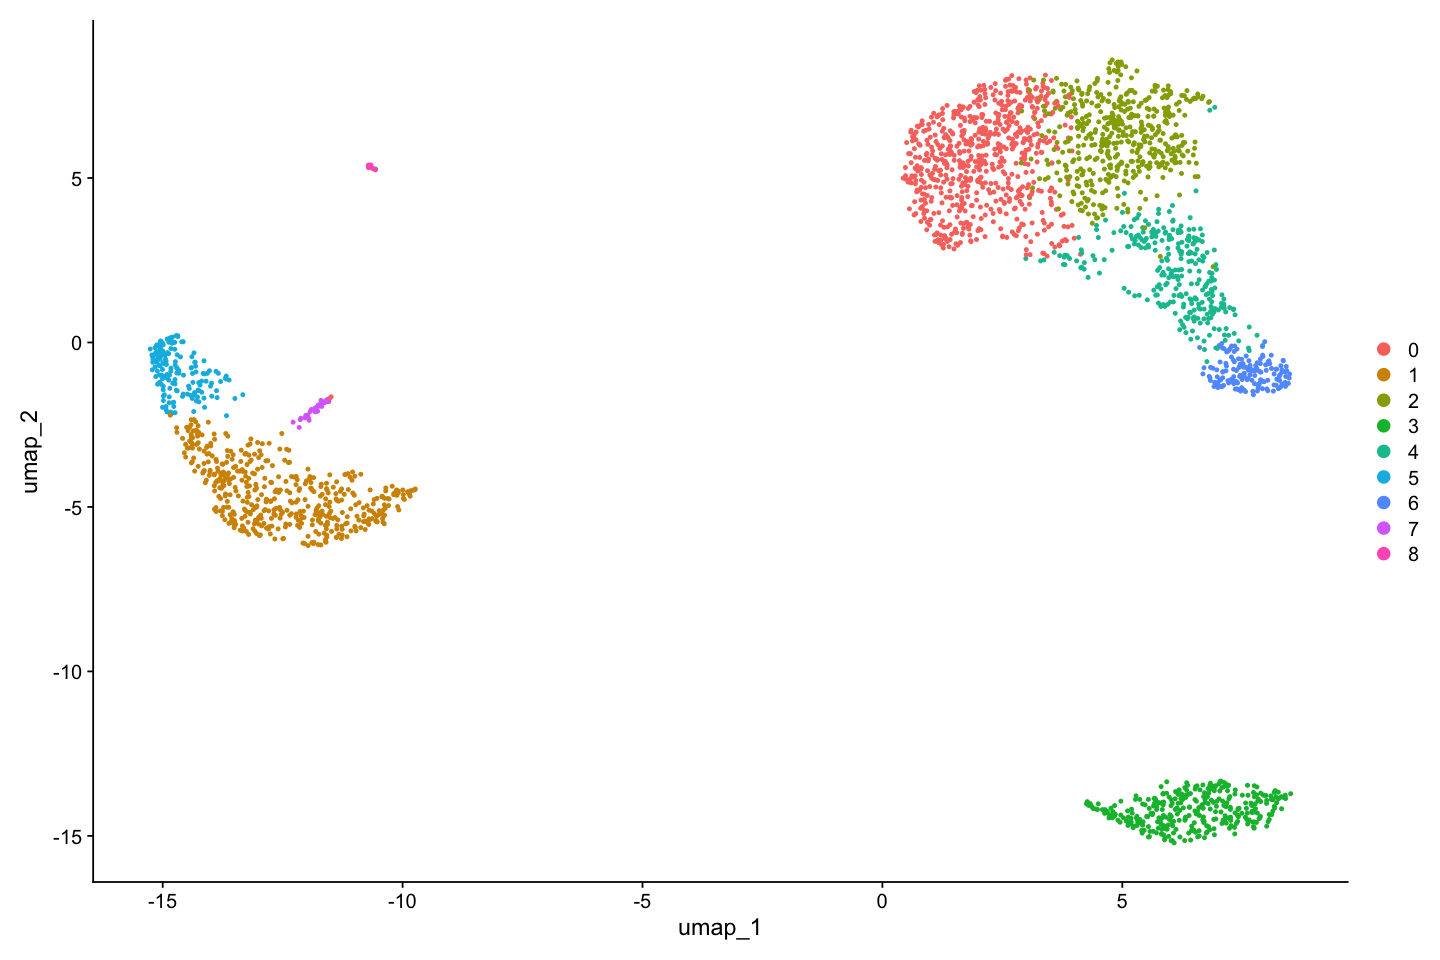

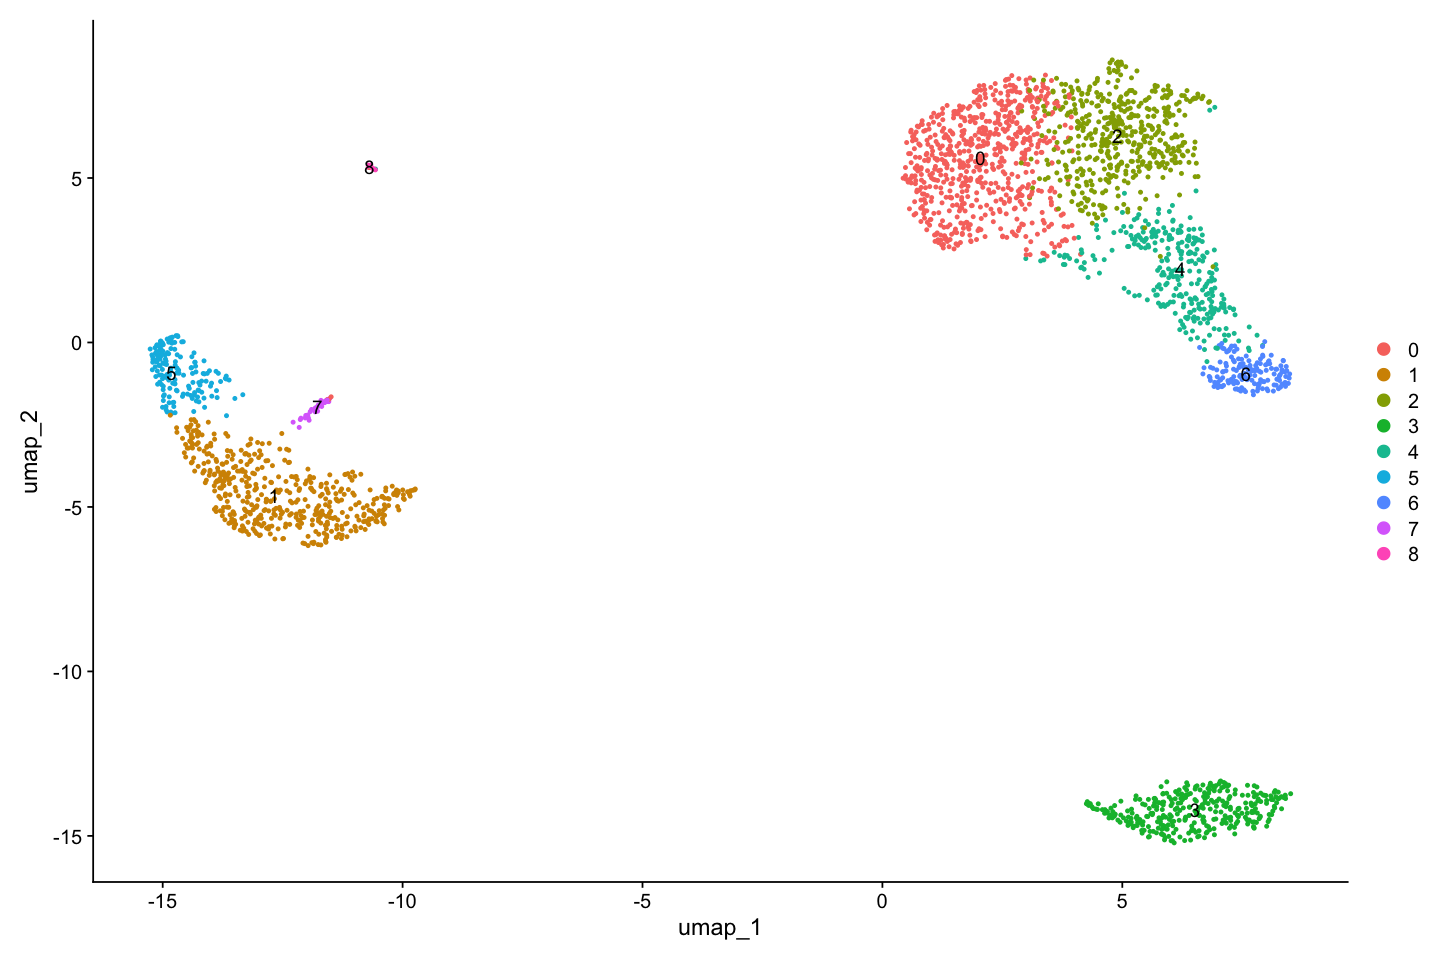

In [10]:
#Clustering & UMAP --------------------------------------------------------
pbmc <- suppressMessages(FindNeighbors(pbmc, dims = 1:10))
pbmc <- suppressMessages(FindClusters(pbmc, resolution = 0.5))
cat("Clusters identified:", length(unique(pbmc$seurat_clusters)), "\n")

pbmc <- suppressWarnings(RunUMAP(pbmc, dims = 1:10))
umap_plot <- DimPlot(pbmc, reduction = "umap")
umap_label_plot <- DimPlot(pbmc, reduction = "umap", label = TRUE)
ggsave(file.path(output_dir, "UMAP_clusters.png"), umap_plot, width = 4, height = 4)
ggsave(file.path(output_dir, "UMAP_clusters_labeled.png"), umap_label_plot, width = 4, height = 4)
umap_plot
umap_label_plot

In [11]:
#Differential expression (markers) ----------------------------------------
pbmc.markers <- suppressMessages(FindAllMarkers(
  pbmc,
  only.pos        = TRUE,
  min.pct         = 0.25,
  logfc.threshold = 0.25
))
#Top 3 markers per cluster
top3_markers <- pbmc.markers %>%
  group_by(cluster) %>%
  slice_max(order_by = avg_log2FC, n = 3) %>%
  arrange(cluster, desc(avg_log2FC))

#Print and save
print(top3_markers, n = Inf)
write.csv(
  as.data.frame(top3_markers),
  file = file.path(output_dir, "top3_markers_per_cluster.csv"),
  row.names = FALSE
)

# A tibble: 27 × 7
# Groups:   cluster [9]
       p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene         
       <dbl>      <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>        
 1 9.57e- 88       2.40 0.447 0.108 1.31e- 83 0       CCR7         
 2 1.35e- 51       2.14 0.342 0.103 1.86e- 47 0       LEF1         
 3 6.27e- 43       1.99 0.33  0.112 8.60e- 39 0       PRKCQ-AS1    
 4 7.07e-139       7.28 0.299 0.004 9.70e-135 1       FOLR3        
 5 3.38e-121       6.74 0.277 0.006 4.64e-117 1       S100A12      
 6 0               6.65 0.975 0.121 0         1       S100A8       
 7 2.97e- 58       2.09 0.42  0.111 4.07e- 54 2       AQP3         
 8 5.03e- 34       1.87 0.263 0.07  6.90e- 30 2       CD40LG       
 9 3.44e- 59       1.63 0.651 0.245 4.71e- 55 2       CD2          
10 2.40e-272       7.38 0.564 0.009 3.29e-268 3       LINC00926    
11 2.75e-237       7.14 0.488 0.007 3.76e-233 3       VPREB3       
12 0               6.91 0.936 0.041 0         3       CD79A        
13 7.

DataFrame with 2638 rows and 4 columns
                                          scores           labels delta.next
                                        <matrix>      <character>  <numeric>
AAACATACAACCAC-1 0.1031269:0.234280:0.222822:...          T_cells  0.0886609
AAACATTGAGCTAC-1 0.0984977:0.361135:0.300626:...           B_cell  0.3046119
AAACATTGATCAGC-1 0.0671635:0.266281:0.237642:...          T_cells  0.1981855
AAACCGTGCTTCCG-1 0.0836640:0.235213:0.273059:...         Monocyte  0.0503585
AAACCGTGTATGCG-1 0.0739783:0.164291:0.175458:...          NK_cell  0.0892199
...                                          ...              ...        ...
TTTCGAACTCTCAT-1 0.0965528:0.249749:0.307289:...         Monocyte  0.1249925
TTTCTACTGAGGCA-1 0.1368350:0.302956:0.269191:... Pre-B_cell_CD34-  0.0276890
TTTCTACTTCCTCG-1 0.0749830:0.272021:0.225157:...           B_cell  0.0618043
TTTGCATGAGAGGC-1 0.0673739:0.232823:0.184013:...           B_cell  0.0790240
TTTGCATGCCTCAC-1 0.0890275:0.242453:0

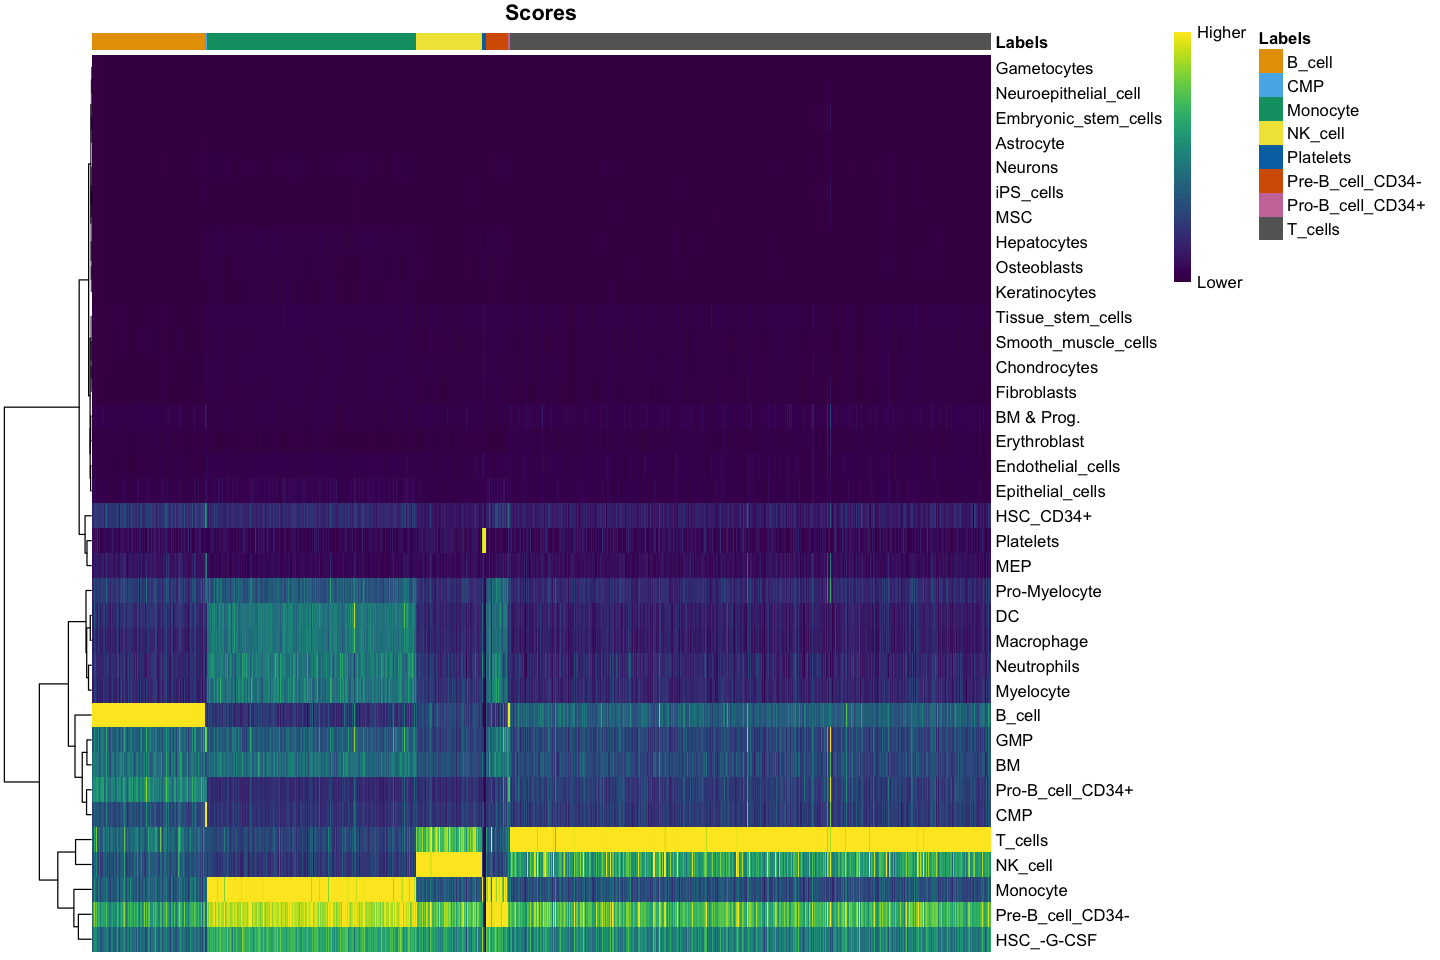

                  Clusters
Assigned             0   1   2   3   4   5   6   7   8
  B_cell             0   0   0 333   0   0   0   0   0
  CMP                4   0   0   0   0   0   0   0   0
  Monocyte           0 433   0   0   0 155   0  27   0
  NK_cell            3   0   1   0  39   0 150   0   0
  Platelets          0   0   0   0   0   0   0   0  12
  Pre-B_cell_CD34-   3  48   1   1   1   6   1   4   0
  Pro-B_cell_CD34+   0   0   0   4   0   0   0   0   1
  T_cells          674   0 474   6 251   1   4   1   0


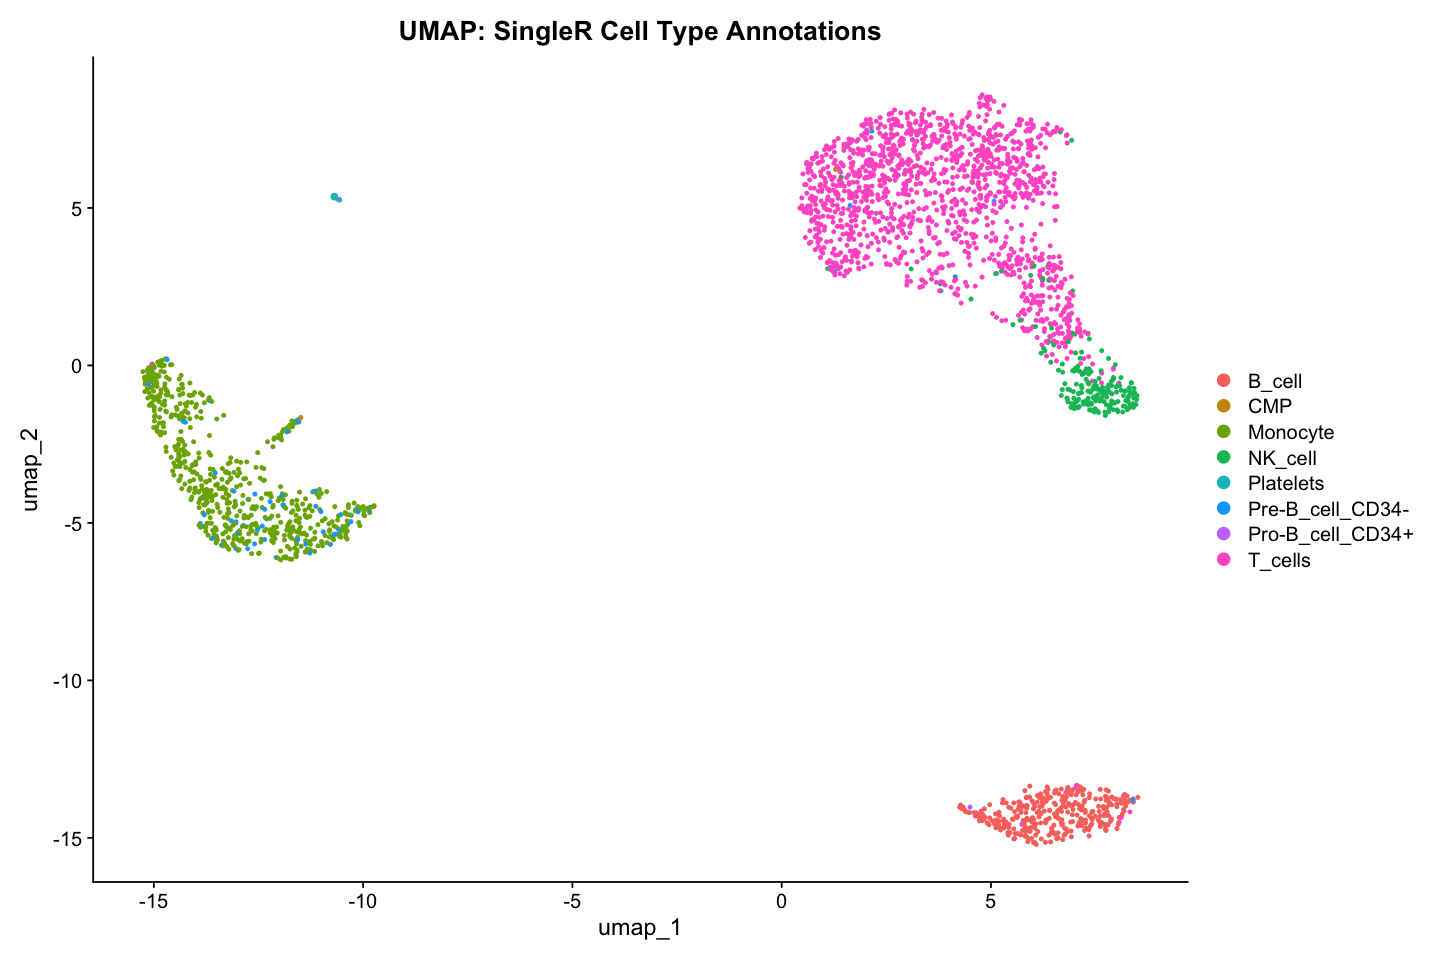

In [12]:
#ANNOTATION ---------------------------------------------------------------
#Load reference dataset
ref <- celldex::HumanPrimaryCellAtlasData()
#Extract raw counts from the Seurat object
pbmc_counts <- GetAssayData(pbmc, layer = "counts")

#Run SingleR to assign cell types
singleR_results <- SingleR(
  test   = pbmc_counts,
  ref    = ref,
  labels = ref$label.main
)

#Print SingleR results and scores matrix
print(singleR_results)
#print(singleR_results$scores)

#Save the score heatmap
score_hm <- plotScoreHeatmap(singleR_results)
ggsave(
  filename = file.path(output_dir, "SingleR_score_heatmap.png"),
  plot     = score_hm,
  width    = 6,
  height   = 6
)

#Add SingleR labels to Seurat metadata
pbmc$SingleR.labels <- singleR_results$labels[
  match(rownames(pbmc@meta.data), rownames(singleR_results))
]

#UMAP colored by SingleR labels
sr_umap <- DimPlot(
  pbmc,
  reduction = "umap",
  group.by  = "SingleR.labels"
) + ggtitle("UMAP: SingleR Cell Type Annotations")
ggsave(
  filename = file.path(output_dir, "UMAP_SingleR_labels.png"),
  plot     = sr_umap,
  width    = 4,
  height   = 4)
sr_umap

#Compare SingleR labels to Seurat clusters
tab <- table(
  Assigned = singleR_results$labels,
  Clusters = pbmc$seurat_clusters)
print(tab)

#Save the contingency table
write.csv(
  as.data.frame(tab),
  file      = file.path(output_dir, "cluster_vs_SingleR_table.csv"),
  row.names = FALSE
)

#Heatmap of the contingency table
contig_hm <- pheatmap(
  log10(tab + 10),
  color = colorRampPalette(c("white","blue"))(10),
  silent = TRUE
)

ggsave(
  filename = file.path(output_dir, "cluster_vs_SingleR_heatmap.png"),
  plot     = contig_hm,
  width    = 6,
  height   = 6
)